### Load and Modify Configuration File

In [1]:
from configs.config_loader import load_config
config = load_config('configs/default.yaml')

version : default
seed : 1
y0 : 0.1
T : 15
N_col : 1024
N_hidden : 4
N_neurons : 50
activation : swish
N_epochs : 20000
learning_rate : 0.001
decay_rate : 1.0
freq_log : 100
freq_print : 1000
keys_print : ['loss']
freq_save : 100
regularization : reg_derivative_unstable_fp
reg_coeff : 1
reg_decay : 1
reg_epochs : 1


### Initialize Physics-Informed Neural Network

In [2]:
from model.neural_net import PhysicsInformedNN
PINN = PhysicsInformedNN(config, verbose=True)

2024-09-19 23:16:18.803590: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-19 23:16:18.863912: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-19 23:16:18.865005: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-19 23:16:19.815401: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Model: "nested_PINN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                100       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 50)                2550      
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7801 (30.47 KB)
Trainable params: 7801 (30.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
*** PINN build & init

### Train Physics-Informed Neural Network

In [3]:
training_log = PINN.train()

Training started...
    0/20000 | loss: 3.34e-02
 1000/20000 | loss: 1.11e-03
 2000/20000 | loss: 1.46e-03
 3000/20000 | loss: 1.34e-03
 4000/20000 | loss: 1.33e-03
 5000/20000 | loss: 1.31e-03
 6000/20000 | loss: 1.44e-03
 7000/20000 | loss: 1.30e-03
 8000/20000 | loss: 1.48e-03
 9000/20000 | loss: 1.35e-03
10000/20000 | loss: 9.75e-04
11000/20000 | loss: 1.38e-03
12000/20000 | loss: 1.49e-03
13000/20000 | loss: 1.31e-03
14000/20000 | loss: 1.33e-03
15000/20000 | loss: 1.24e-03
16000/20000 | loss: 1.38e-03
17000/20000 | loss: 1.23e-03
18000/20000 | loss: 1.45e-03
19000/20000 | loss: 1.80e-03
*** logs saved ***
### Training finished ###


# Plot Section

In [4]:
from model.plots import learning_curves, toy_example_dynamics

### Learning Curves

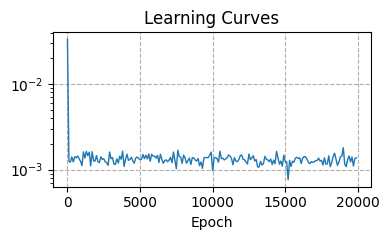

In [5]:
learning_curves(training_log)

### Toy Example Dynamics

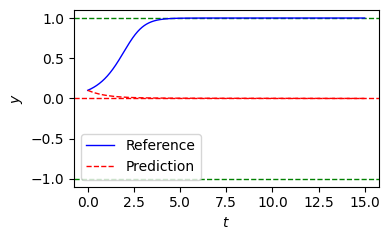

In [6]:
toy_example_dynamics(PINN)

### Training animation

In [7]:
import matplotlib.pyplot as plt
import os
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML



def init_fig():

    fig, ax = plt.subplots()

    #############################
    ### Initial plot comes here
    #############################

    plt.tight_layout()
    plt.close(fig)
    return fig, ax


def animate(i, *fargs):
    # get passed arguments
    ax = fargs[0]
    N_times = fargs[1]

    # print status of animation
    print(f'Processed: {i/N_times*100:.0f}%', end='\r')

    # clear axis
    ax.clear()

    #############################
    ### load model weights & make predictions
    #############################
    flag = i * config['freq_save']
    PINN.load_weights(PINN.log_path.joinpath(f'model_weights/weights_{flag}.pkl'))
    # get (equally-spaced) data points
    t_line = PINN.data.t_line()
    # get reference solution (analytical)
    y_true = PINN.data.reference(t_line)
    # get PINN prediction
    y_pred = PINN(t_line)

    #############################
    ### Updated plot comes here
    #############################

    # include fixed point lines
    for y_fix in [-1, 1]:
        ax.axhline(y_fix, lw=1, ls='--', c='green')
    ax.axhline(0, lw=1, ls='--', c='red')

    # make plots
    ax.plot(t_line, y_true, c='blue', lw=1, label='Reference')
    ax.plot(t_line, y_pred, c='red', lw=1, ls='--', label='Prediction')

    # Axis appearance
    ax.legend()
    ax.set_ylabel(r'$y$')
    ax.set_xlabel(r'$t$')


    plt.tight_layout()


# should equal the number of saved weights files
N_frames = int(config["N_epochs"] / config["freq_save"])

(fig, ax) = init_fig()
ani = FuncAnimation(fig, animate, frames=N_frames, fargs=(ax, N_frames))
HTML(ani.to_jshtml())

<Figure size 640x480 with 0 Axes>